In [1]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!nvidia-smi

Mon Nov  7 08:13:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
DATA_ROOT = '/content/drive/MyDrive/VMM/data'
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import numpy as np
from pydub import AudioSegment
from torch.utils.data import Dataset, DataLoader
import glob
from sklearn.manifold import TSNE
import pandas as pd
import torch.nn as nn
import os

# Songs visualization and preprocessing

In [5]:
class SegmentedSong:
    def __init__(self, path: str, fmt: str = 'wav', window: int = 400, shift: int = 1):
        self.path = path
        self.window = window
        self.shift = shift
        self.spec_data = None
        try:
            self.song = AudioSegment.from_file(path, format=fmt)
            self.spec_data = self.__get_spec_data(*self.__convert_to_librosa(self.song))
        except:
            pass
        
    def __len__(self):
        if self.spec_data is None:
          return 0
        else:
          return int(self.spec_data.shape[1] - self.window) // self.shift
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if not self.song:
            raise StopIteration
            
        if self.n < int(self.spec_data.shape[1] - self.window) // self.shift:
            self.n += 1
            spec_segment = self.at(self.n)
            return spec_segment
        else:
            raise StopIteration

    def at(self, index):
      return self.spec_data[:, index*self.shift:(index*self.shift + self.window)]
    
    @staticmethod
    def __convert_to_librosa(segment):
        samples = segment.get_array_of_samples()
        y = np.array(samples).astype(np.float32)/32768 # 16 bit
        return y, segment.frame_rate
    
    @staticmethod
    def __get_spec_data(y, samplerate):
        # this is the number of samples in a window per fft
        n_fft = 2048
        # The amount of samples we are shifting after each fft
        hop_length = 512

        mel_signal = librosa.feature.melspectrogram(y=y, sr=samplerate, hop_length=hop_length, n_fft=n_fft)
        spectrogram = np.abs(mel_signal)
        power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
        return power_to_db

In [6]:
song = SegmentedSong(f"{DATA_ROOT}/reggae/reggae.00000.wav", fmt='wav')

In [7]:
len(song)

893

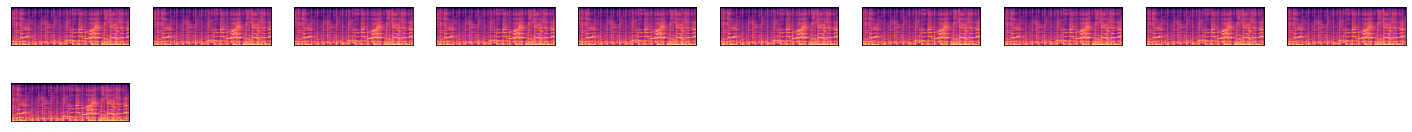

In [8]:
window = 10

fig = plt.figure(figsize=(25, 4))
fig.tight_layout()
for i, spec_data in enumerate(song):
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(spec_data, origin="lower", cmap=plt.get_cmap("magma"))
    if i == 10:
        break

# Creating AutoEncoder

In [9]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Flatten(start_dim=1),
            nn.Linear(400*16*2, 500),
            nn.ReLU(True),
            nn.Linear(500, 300)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(300, 500),
            nn.ReLU(True),
            nn.Linear(500, 400*16*2),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(4, 32, 100)),
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        compressed = x
        x = self.decoder(x)
        return x, compressed

autoencoder = ConvAutoencoder()
print(autoencoder)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=12800, out_features=500, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=500, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=12800, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(4, 32, 100))
    (5): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(16

In [ ]:
image = next(iter(song))

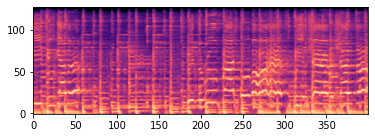

In [ ]:
plt.imshow(image, origin="lower", cmap=plt.get_cmap("magma"))
plt.show()

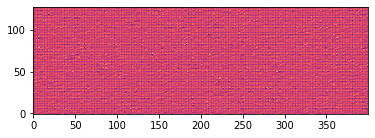

In [ ]:
img, compressed = autoencoder(torch.Tensor(np.array([image])).view(1, 1, 128, 400))
plt.imshow(img.view(128, 400).detach().numpy(), origin="lower", cmap=plt.get_cmap("magma"))
plt.show()

# Creating dataset and loader

In [10]:
class SongSegmentsDataset(Dataset):
    def __init__(self, root_dir, from_slice=0, to_slice=20):
        self.root_dir = root_dir
        self.from_slice=from_slice
        self.to_slice=to_slice
        self.songs = self.__get_songs()

    def __len__(self):
        return sum(map(lambda x: len(x), self.songs))

    def __getitem__(self, idx):
        for song in self.songs:
          if idx - len(song) >= 0:
            idx -= len(song)
          else:
            sample = song.at(idx)
            return sample
    
    def __get_songs(self):
        genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
        songs_list = []
        for genre in genres:
            songs_list += [path for path in glob.glob(f'{self.root_dir}/{genre}/*')][self.from_slice:self.to_slice]
        return [SegmentedSong(song_path, fmt='wav') for song_path in songs_list]

In [ ]:
train_dataset = SongSegmentsDataset(DATA_ROOT, from_slice=0, to_slice=2)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

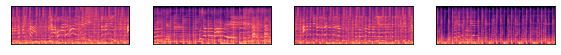

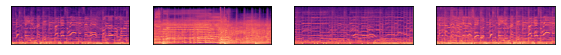

In [ ]:
for i_batch, sample_batched in enumerate(train_loader):
    fig = plt.figure(figsize=(25, 4))
    fig.tight_layout()
    for i, sample in enumerate(sample_batched):
        ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
        ax.imshow(sample, origin="lower", cmap=plt.get_cmap("magma"))
    if i_batch == 1:
        break

# Training the model

In [11]:
class TrainTester:
    def __init__(self, device, model):
        self.device = device
        self.model = model.to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train_test(self, train_loader, test_loader, num_epochs=20):
        train_loss_output = []
        test_loss_output = []

        for epoch in range(1, num_epochs + 1):
            print(f'Epoch {epoch}')
            tr_loss = self.train(train_loader)
            print('\tTraining Loss: {:.6f}'.format(tr_loss))
            ts_loss = self.test(test_loader)
            print('\tTest Loss: {:.6f}'.format(ts_loss))

            train_loss_output.append(tr_loss)
            test_loss_output.append(ts_loss)
        return train_loss_output, test_loss_output
        
    def train(self, train_loader):
        self.model.train()
        train_loss = 0

        self.model.zero_grad()
        for images in train_loader:    
            images = images.to(self.device)
            images = images.view(-1, 1, 128, 400)

            outputs, _ = self.model(images)

            loss = self.criterion(outputs, images)

            train_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            self.model.zero_grad()

        train_loss /= len(train_loader)
        return train_loss
    
    def test(self, test_loader):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for images in test_loader:

                images = images.to(self.device)
                images = images.view(-1, 1, 128, 400)
                
                outputs, _ = self.model(images)

                test_loss += self.criterion(outputs, images).item()
        test_loss /= len(test_loader)
        return test_loss

In [ ]:
train_dataset = SongSegmentsDataset(DATA_ROOT, from_slice=0, to_slice=70)
test_dataset = SongSegmentsDataset(DATA_ROOT, from_slice=71, to_slice=99)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=0)

In [ ]:
print(f'Train data points: {len(train_dataset)}')
print(f'Test data points: {len(test_dataset)}')

Train data points: 624834
Test data points: 250040


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tt = TrainTester(device, autoencoder)  
train_losses, test_losses = tt.train_test(train_loader, test_loader, 50)

Epoch 1
	Training Loss: 122.288486
	Test Loss: 72.137324
Epoch 2
	Training Loss: 69.675311
	Test Loss: 68.524447
Epoch 3
	Training Loss: 68.278468
	Test Loss: 65.984893
Epoch 4
	Training Loss: 67.121831
	Test Loss: 65.484026
Epoch 5
	Training Loss: 66.539843
	Test Loss: 65.457734
Epoch 6
	Training Loss: 66.158428
	Test Loss: 65.021621
Epoch 7
	Training Loss: 65.954648
	Test Loss: 64.974917
Epoch 8
	Training Loss: 65.764299
	Test Loss: 64.842427
Epoch 9
	Training Loss: 65.637607
	Test Loss: 64.874647
Epoch 10
	Training Loss: 65.507882
	Test Loss: 64.726209
Epoch 11
	Training Loss: 65.398734
	Test Loss: 64.665542
Epoch 12
	Training Loss: 65.313017
	Test Loss: 64.680729
Epoch 13
	Training Loss: 65.147060
	Test Loss: 64.490974
Epoch 14
	Training Loss: 64.646530
	Test Loss: 64.782462
Epoch 15
	Training Loss: 64.489425
	Test Loss: 64.024458
Epoch 16
	Training Loss: 64.339915
	Test Loss: 63.897919
Epoch 17
	Training Loss: 64.228056
	Test Loss: 64.043624
Epoch 18
	Training Loss: 64.164664
	Tes

KeyboardInterrupt: ignored

In [ ]:
torch.save(autoencoder.state_dict(), f'/content/drive/MyDrive/VMM/autoencoder.pth')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train loss', color='b')
plt.show(test_losses, label='Test loss', color='r')
plt.grid(True)
plt.title('Train and test losses during model training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/VMM/autoencoder.pth'))

FileNotFoundError: ignored

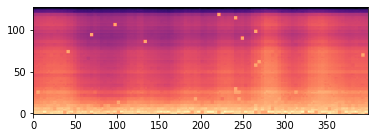

In [ ]:
input = torch.Tensor(np.array([image])).view(1, 1, 128, 400)
img, compressed = autoencoder(input.to(device))
plt.imshow(img.view(128, 400).detach().cpu().numpy(), origin="lower", cmap=plt.get_cmap("magma"))

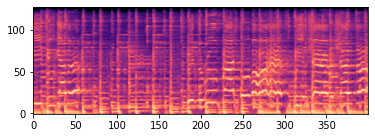

In [ ]:
plt.imshow(image, origin="lower", cmap=plt.get_cmap("magma"))

## Creating weighted vectors for songs with the learnt model

In [ ]:
class WeightedSongEmbedding:
  def __init__(self, path, genre, fmt='wav'):
    self.path = path
    self.segments = SegmentedSong(path, fmt=fmt, shift=20)
    self.embedding = None
    self.genre = genre
  
  def calculate_embedding(self, autoencoder):
    if self.embedding is not None:
      return self.embedding
    embeddings = self.__calculate_embeddings(autoencoder)
    return np.mean(embeddings, axis=0)

  def __calculate_embeddings(self, autoencoder):
    embeddings = np.ones(300)
    for segment in iter(self.segments):
      input = torch.Tensor(np.array([segment])).view(1, 1, 128, 400)
      _, embedding = autoencoder(input)
      detached = embedding.detach().numpy()
      embeddings = np.vstack([embeddings, detached])
    return embeddings[1:]

In [ ]:
emb = WeightedSongEmbedding(f"{DATA_ROOT}/reggae/reggae.00000.wav", 'reggae').calculate_embedding(autoencoder)

In [ ]:
len(emb)

300

In [ ]:
class EmbsVisualizer:
    def __init__(self, root_dir, autoencoder, songs_per_genre = 10):
      self.root_dir = root_dir
      self.songs_per_genre = songs_per_genre
      self.autoencoder = autoencoder
      self.genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
      self.songs = self.__get_songs_per_genre()

    def visualize_embeddings(self):
      embs = self.__get_embeddings()
      reduced = self.__tsne_reduce(embs, perplexity=20)
      plt.figure(figsize=(12, 6))
      scatter = plt.scatter(reduced[1], reduced[2], c=reduced.genre, cmap='jet')
      handles, _ = scatter.legend_elements()
      plt.legend(handles=handles, loc="lower right", title="Genre", labels=self.genres)
      plt.show()

    def __get_embeddings(self):
      arr = [song_emb for songs in self.songs.values() for song_emb in songs.values()]
      embs = pd.DataFrame(map(lambda x: [x.genre] + x.calculate_embedding(self.autoencoder).ravel().tolist(), arr))
      embs.rename(columns={0: 'genre'}, inplace=True)
      embs = self.__remap_genres(embs)
      return embs

    def __remap_genres(self, embs):
      genres_mapping = {self.genres[i]: i for i in range(len(self.genres))}
      embs.genre = embs.apply(lambda x: genres_mapping[x.genre], axis=1)
      return embs

    def __get_songs_per_genre(self):
      songs = {key: {} for key in self.genres}
      for song_path, genre in self.__iterate_songs():
        song_emb = WeightedSongEmbedding(song_path, genre)
        songs[genre][song_path] = song_emb
      return songs

    def __iterate_songs(self):
      for genre in self.genres:
        arr = [self.__path_for_song(genre, idx) for idx in range(self.songs_per_genre)]
        for item in arr:
          yield item, genre

    def __path_for_song(self, genre: str, idx: int):
      return os.path.join(self.root_dir, genre, f"{genre}.{'{:05d}'.format(idx)}.wav")

    @staticmethod
    def __tsne_reduce(df: pd.DataFrame, perplexity: int = 30) -> pd.DataFrame:
      """
      Reduces the dataset into 2 dimensions using t-SNE dimensionality reduction
      :param perplexity: Perplexity of t-SNE dimensionality reduction
      :param df: Dataset of learned representations
      :return: Learned representations reduced to 2 dimensions
      """
      feature_cols = [x for x in df.columns if isinstance(x, int)]
      x = df.loc[:, feature_cols]
      tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200, init='random')
      tsne_results = tsne.fit_transform(x)
      cols = [col + 1 for col in range(2)]
      tsne_df = pd.DataFrame(data=tsne_results, columns=cols)
      return pd.concat([tsne_df, df[['genre']]], axis=1)

In [ ]:
vis = EmbsVisualizer(DATA_ROOT, autoencoder, 50)

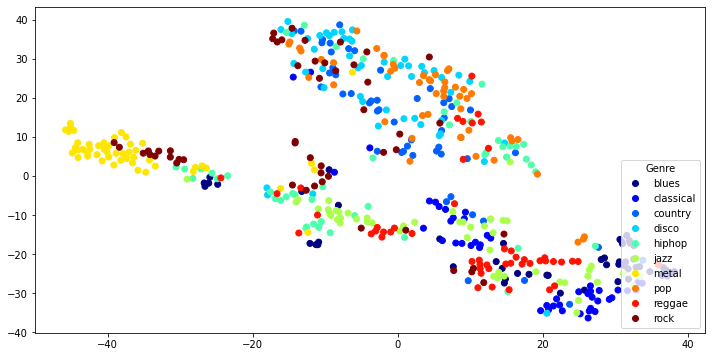

In [ ]:
vis.visualize_embeddings()